In [2]:
from pathlib import Path
import pprint
import os


__file__ = os.getcwd()
data_paths = [Path(__file__) / 'data' / 'dbCAN2' / 'CAZyDB.07312018.fa']

pprint.pprint([str(path) for path in data_paths])

['/home/sunmoon/workspace/eCAMI/data/dbCAN2/CAZyDB.07312018.fa']


In [5]:
from tqdm import tqdm
import pandas as pd
import hashlib


class Protein:
    def __init__(self, name='', families='', sequence='', sequence_hash=''):
        self.name = name
        self.families = families
        self.sequence = sequence
        self.sequence_hash = sequence_hash
        
    def hash_sequence(self):
        self.sequence_hash = hashlib.sha1((self.sequence + self.families).encode('ascii')).hexdigest()

    def to_list(self):
        return [self.name, self.families, self.sequence, self.sequence_hash]
        
    def __repr__(self):
        return f'''\r{self.name}
        \r{self.families}
        \r{self.sequence[:20]}...{len(self.sequence)}...{self.sequence[-5:]}
        \r{self.sequence_hash}'''


proteins = []
temp_protein = None

for data_path in data_paths:
    data_file = open(data_path, 'r')

    for line in tqdm(data_file):
        line = line.strip().upper()

        if line[-1] == '|':
            line = line[:-1]
        
        if line[0] == '>':
            if temp_protein is not None:
                temp_protein.hash_sequence()
                proteins.append(temp_protein.to_list())
            
            temp_protein = Protein()

            try:
                name, families = line.split('|', 1)
            except:
                print(f'\n[ERROR] format error: {line}')
                name = line
                families = ''
            
            name = name[1:]
            
            temp_protein.name = name

            temp_families = []
            for family in families.split('|'):
                if family[0].isalpha():
                    temp_families.append(family)

            families = ''
            for family in sorted(temp_families):
                families += family
                families += '|'
            
            families = families[:-1]
            
            temp_protein.families = families
            
        else:
            temp_protein.sequence += line

columns = ['name', 'families', 'sequence', 'sequence_hash']
protein_df = pd.DataFrame(proteins, columns=columns)
print(f'Protein DF shape: {protein_df.shape}')

protein_df = protein_df.drop_duplicates(subset=['sequence', 'families'], keep='first')
print(f'Unique protein DF shape: {protein_df.shape}')

protein_df = protein_df.drop_duplicates(subset=['sequence'], keep=False)
print(f'Dropped duplicated seq w/ unmatched family protein DF shape: {protein_df.shape}')

2134124it [00:10, 196286.44it/s]
Protein DF shape: (1066326, 4)
Unique protein DF shape: (636611, 4)
Dropped duplicated seq w/ unmatched family protein DF shape: (636587, 4)


In [6]:
from tqdm import tqdm
import pickle
import json
import pprint


def append_key(family_dict, family_levels, protein):
    total_levels = len(family_levels)
    
    cw_dict = family_dict
    
    for i in range(total_levels):
        if family_levels[i] not in cw_dict:
            cw_dict[family_levels[i]] = {
                '_count' : 0,
                '_sub_count' : 1,
                '_elements' : [],
            }
            
        else:
            cw_dict[family_levels[i]]['_sub_count'] += 1
            
        cw_dict = cw_dict[family_levels[i]]
        
        if i == total_levels-1 :
            cw_dict['_count'] += 1
            cw_dict['_elements'].append(protein)

def append_key_count(family_dict, family_levels):
    total_levels = len(family_levels)
    
    cw_dict = family_dict
    
    for i in range(total_levels):
        if family_levels[i] not in cw_dict:
            cw_dict[family_levels[i]] = {
                '_count' : 0,
                '_sub_count' : 1,
            }
            
        else:
            cw_dict[family_levels[i]]['_sub_count'] += 1
            
        cw_dict = cw_dict[family_levels[i]]
        
        if i == total_levels-1 :
            cw_dict['_count'] += 1
            
family_dict = {}
family_count_dict = {}

for _, protein in tqdm(protein_df.iterrows()):
    family_levels_list = [family.replace('.', '_').split('_') for family in protein['families'].split('|')]

    for family_levels in family_levels_list:
        append_key(family_dict, family_levels, Protein(name=protein['name'],
                                                       families=family_levels_list,
                                                       sequence=protein['sequence'],
                                                       sequence_hash=protein['sequence_hash']))
        append_key_count(family_count_dict, family_levels)

family_dict = sorted(family_dict.items())
family_count_dict = sorted(family_count_dict.items())

out_filename = 'family_count.json'
out_file = open(out_filename, 'w')
json.dump(family_count_dict, out_file)
out_file.close()

print('JSON created')
pprint.pprint(family_count_dict)

unt': 1022},
   '19': {'_count': 783, '_sub_count': 783},
   '2': {'_count': 216, '_sub_count': 216},
   '20': {'_count': 1099, '_sub_count': 1099},
   '21': {'_count': 726, '_sub_count': 726},
   '22': {'_count': 51, '_sub_count': 51},
   '23': {'_count': 879, '_sub_count': 879},
   '24': {'_count': 157, '_sub_count': 157},
   '25': {'_count': 136, '_sub_count': 136},
   '26': {'_count': 1705, '_sub_count': 1705},
   '27': {'_count': 196, '_sub_count': 196},
   '28': {'_count': 221, '_sub_count': 221},
   '29': {'_count': 1683, '_sub_count': 1683},
   '3': {'_count': 1507, '_sub_count': 1507},
   '30': {'_count': 1120, '_sub_count': 1120},
   '31': {'_count': 2612, '_sub_count': 2612},
   '32': {'_count': 410, '_sub_count': 410},
   '33': {'_count': 210, '_sub_count': 210},
   '34': {'_count': 31, '_sub_count': 31},
   '35': {'_count': 20, '_sub_count': 20},
   '36': {'_count': 218, '_sub_count': 218},
   '37': {'_count': 129, '_sub_count': 129},
   '38': {'_count': 326, '_sub_count':

In [7]:
out_filename = 'family.pickle'
out_file = open(out_filename, 'wb')
pickle.dump(family_dict, out_file)
out_file.close()

In [8]:
out_filename = 'family_count.pickle'
out_file = open(out_filename, 'wb')
pickle.dump(family_count_dict, out_file)
out_file.close()

In [6]:
print('protein counts:')

for family in family_count_dict:
    family_name = family[0]
    family_count = family[1]['_sub_count']
    if len(family[1]) > 2:
        print(f'{family_name}\t{family_count}')

        length = len(family[1])
        count = 0
        for sub in family[1]:
            count += 1

            if sub[0] != '_':
                i = family[1][sub]['_sub_count']
                tree_str = '├──'
                if length == count:
                    tree_str = '└──'
                    print(f' {tree_str} {sub}\t{i}')
                    print()
                else:
                    print(f' {tree_str} {sub}\t{i}')

protein counts:
AA1	1578
 ├── 3	172
 ├── 2	188
 └── 1	513

AA3	912
 ├── 2	684
 ├── 1	101
 ├── 3	62
 └── 4	17

AA5	259
 ├── 1	69
 └── 2	132

GH13	36512
 ├── 11	3920
 ├── 16	1741
 ├── 39	273
 ├── 3	1507
 ├── 31	2612
 ├── 10	1761
 ├── 29	1683
 ├── 38	326
 ├── 18	1022
 ├── 9	3806
 ├── 23	879
 ├── 13	627
 ├── 21	726
 ├── 30	1120
 ├── 36	218
 ├── 26	1705
 ├── 5	1109
 ├── 37	129
 ├── 20	1099
 ├── 27	196
 ├── 32	410
 ├── 19	783
 ├── 12	283
 ├── 41	86
 ├── 14	1035
 ├── 8	578
 ├── 15	643
 ├── 40	257
 ├── 33	210
 ├── 42	66
 ├── 2	216
 ├── 25	136
 ├── 1	178
 ├── 7	133
 ├── 28	221
 ├── 17	140
 ├── 34	31
 ├── 24	157
 ├── 4	340
 ├── 6	246
 ├── 22	51
 └── 35	20

GH30	1414
 ├── 5	139
 ├── 1	262
 ├── 3	412
 ├── 8	234
 ├── 6	6
 ├── 4	83
 ├── 7	37
 ├── 2	125
 └── 9	27

GH43	7360
 ├── 26	1016
 ├── 31	66
 ├── 9	186
 ├── 34	341
 ├── 24	348
 ├── 3	160
 ├── 17	91
 ├── 4	378
 ├── 33	39
 ├── 1	306
 ├── 11	864
 ├── 2	55
 ├── 10	533
 ├── 16	244
 ├── 28	138
 ├── 18	123
 ├── 12	545
 ├── 5	336
 ├── 22	204
 ├── 27	52


In [9]:
root_family_names = ['AA', 'CBM', 'CE', 'GH', 'GT', 'PL']
root_family_names_count = [0, 0, 0, 0, 0, 0]

root_family_dict = dict(zip(root_family_names, root_family_names_count))
print(root_family_dict)

for family in family_count_dict:
    family_name = family[0]
    for root_family_name in root_family_names:
        if family_name.startswith(root_family_name):
            root_family_dict[root_family_name] += 1
    
print(root_family_dict)

{'AA': 0, 'CBM': 0, 'CE': 0, 'GH': 0, 'GT': 0, 'PL': 0}
{'AA': 16, 'CBM': 82, 'CE': 16, 'GH': 148, 'GT': 103, 'PL': 28}


In [10]:
proteins = []
single_family_proteins = []
multi_family_proteins = []

for _, protein in tqdm(protein_df.iterrows()):
    family_levels_list = [family.replace('.', '_').split('_') for family in protein['families'].split('|')]
    proteins.append(Protein(name=protein['name'],
                    families=family_levels_list,
                    sequence=protein['sequence'],
                    sequence_hash=protein['sequence_hash']))

for protein in proteins:
    if len(protein.families) > 1:
        multi_family_proteins.append(protein)
    else:
        single_family_proteins.append(protein)

print()
print('proteins:', len(proteins))
print('single family proteins:', len(single_family_proteins))
print('multi family proteins:', len(multi_family_proteins))

636587it [01:00, 10460.87it/s]

proteins: 636587
single family proteins: 591395
multi family proteins: 45192


multi_family_proteins ratio: 8.1752 %
max: 7
avg: 2.1197
min: 2


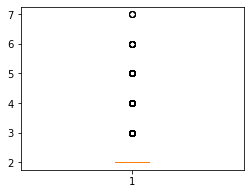

In [10]:
import matplotlib.pyplot as plt

print(f'multi_family_proteins ratio: {round(len(multi_family_proteins) * 100 / len(proteins), 4)} %')

families_counts = []
for protein in multi_family_proteins:
    families_counts.append(len(protein.families))

print(f'max: {max(families_counts)}')
print(f'avg: {round(sum(families_counts) / len(families_counts), 4)}')
print(f'min: 2')

fig = plt.figure(figsize=(4, 3))
plt.boxplot(families_counts)
plt.show()

In [14]:
single_family_sequence_lengths = []
multi_family_sequence_lengths = []

for protein in single_family_proteins:
    single_family_sequence_lengths.append(len(protein.sequence))

for protein in multi_family_proteins:
    multi_family_sequence_lengths.append(len(protein.sequence))

print(f'single_family_sequence_length')
print(f'max: {max(single_family_sequence_lengths)}')
print(f'avg: {round(sum(single_family_sequence_lengths) / len(single_family_sequence_lengths), 4)}')
print(f'min: {min(single_family_sequence_lengths)}')
print()

print(f'multi_family_sequence_length')
print(f'max: {max(multi_family_sequence_lengths)}')
print(f'avg: {round(sum(multi_family_sequence_lengths) / len(multi_family_sequence_lengths), 4)}')
print(f'min: {min(multi_family_sequence_lengths)}')

single_family_sequence_length
max: 10270
avg: 464.8222
min: 11

multi_family_sequence_length
max: 5926
avg: 731.2718
min: 10
